In [365]:
import torch
import torch.nn as nn
import numpy as np

import PIL.Image as Image
import matplotlib.pyplot as plt

**Firstly, you install all the pytorch packages by importing the torch libraries above as shown above.**

**Let's create a random image data array. Say it's a 32 by 32 black-and-white pixel image.**

In [366]:
img = np.random.uniform(0, 1, size=(1, 1, 32, 32))
img

array([[[[0.6063012 , 0.54967946, 0.00154616, ..., 0.35343838,
          0.09142447, 0.44434983],
         [0.42552126, 0.68634622, 0.04294206, ..., 0.34019779,
          0.32486761, 0.56017614],
         [0.78396597, 0.44993023, 0.98760553, ..., 0.00121494,
          0.33540856, 0.51243502],
         ...,
         [0.96956422, 0.11109589, 0.59022536, ..., 0.84303002,
          0.7483073 , 0.95650451],
         [0.81154883, 0.66999489, 0.94750721, ..., 0.47365276,
          0.30178989, 0.47881601],
         [0.7215737 , 0.64049223, 0.2452134 , ..., 0.71295936,
          0.80275813, 0.66278304]]]])

In [367]:
img.shape

(1, 1, 32, 32)

**We put it in 1 by 1 by 32 by 32 pixel format because it is 1 batch of 1 channels of 32 by 32 pixel data - for now.**

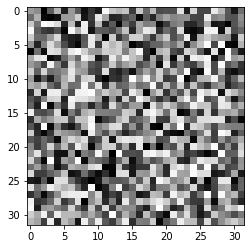

In [368]:
plt.imshow(img[0][0], cmap='gray')

**This is only random data for now. We can't classify this as anything but we will attempt to use this junk as demonstration to learn how Resnet CNN works.**

In [369]:
conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 5, stride = 2, padding = 2),
        nn.BatchNorm2d(num_features = 4),
        nn.ReLU())

max_pool = nn.MaxPool2d((2, 2), stride = 2)

next_convs = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())

fc = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10))

**Before inputting your data, always make sure that your input-data is a torch tensor variable. Otherwise, back-propagation won't be possible**

In [370]:
img = torch.tensor(img, dtype = torch.float32)
img.shape

torch.Size([1, 1, 32, 32])

In [371]:
img = conv1(img)
img.shape

torch.Size([1, 4, 16, 16])

**After running through the convolution layer, the data turned from 1 batch of 1 channel of 32 by 32 pixel data to 1 batch of 4 channels of 16 by 16 pixel data. This is due to the 5 by 5 kernel that passed over pixel data.**

In [372]:
img = max_pool(img)
img.shape

torch.Size([1, 4, 8, 8])

**Max pooling simply takes the maximum data value in a *x* by *y* kernel. For every 2 by 2 block in *img*, we pooled only the maximum value, therefore the image turned into 1 batch by 4 channels of 8 by 8 pixel data.**

In [373]:
img = next_convs(img)
img.shape

torch.Size([1, 16, 4, 4])

**Although there is only 1 layer of convolutions in this example, the data will pass through multiple layers of convolutions as shown in the example above.**

In [374]:
img = img.view(img.shape[0], -1)
img.shape

torch.Size([1, 256])

**After this, flatten the data into your batch amount by 1 line of data so that it may be passed through a fully connected layer.**

In [375]:
img = fc(img)
img.shape

torch.Size([1, 10])

**After passing through the fully-connected layer, you can classify what the image data holds by looking at what it could be of 10 choices.**

**Of course, the above was only a simplified version of a resnet network. A real resnet network looks like what would be shown below.**

In [376]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [377]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )